### Workflow

1.  Create a class that inherits from nn.Module and implement the following methods:
    * __init__ (put the convolutional blocks here)
    * forward (this will take a properly formatted T1-w image as input and, once trained, output an approximate T2-w image of the same shape as the input image)
2.  Verify that the forward pass works by running an image from the training set through the network. Check that the input shape is the same as the output shape.

In [1]:
import os
from nifti_dataset import NiftiDataset, RandomCrop3D, ToTensor
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2


input_dir = "/home/nbaranov/projects/04_cv/MedicalImageAnalysis/data/small_data/small/"
f_size = (14,8)

t1_dir = os.path.join(input_dir, 't1')
t2_dir = os.path.join(input_dir, 't2')

In [29]:
ds = NiftiDataset(source_dir=t1_dir,
                  target_dir=t2_dir,
                  transform=[RandomCrop3D(output_size=(32, 32, 90)), ToTensor()],
                  preload=False,
                  )

img1, img2 = ds.__getitem__(0)
print(img1.shape)

torch.Size([1, 32, 32, 90])


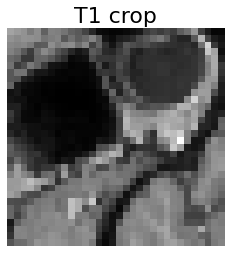

In [34]:
plt.imshow(img1.squeeze(0)[:,:,30], cmap='gray')
plt.title('T1 crop', fontsize=22)
plt.axis('off');

In [35]:
import torch
import torch.nn as nn

conv = nn.Conv3d(in_channels=90, out_channels=90, kernel_size=(5,5,5), padding=2)#.float()

In [45]:
img1.view(1, 90, 32, 32).unsqueeze(2).float().shape

torch.Size([1, 90, 1, 32, 32])

In [48]:
output = conv(img1.view(1, 90, 32, 32).unsqueeze(2).float())
print(output.shape)

torch.Size([1, 90, 1, 32, 32])


In [ ]:
from torch import nn

class ConvNet(nn.Module):
    def __init__(self, args):
        super().__init__()
        # fill this in, add conv. layers here

    def forward__(self, x):
        # fill this in with calls to the defined conv. Layers
        # return the resulting transformed x